# Graph Isomorphism Networks

> Chapter 4 of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course)

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne).

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/gin/

In [1]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

     |████████████████████████████████| 7.9 MB 31.8 MB/s 
     |████████████████████████████████| 3.5 MB 23.3 MB/s 


# Dataset

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 27
Number of features: 0
Number of classes: 2


Done!


# 3D plot

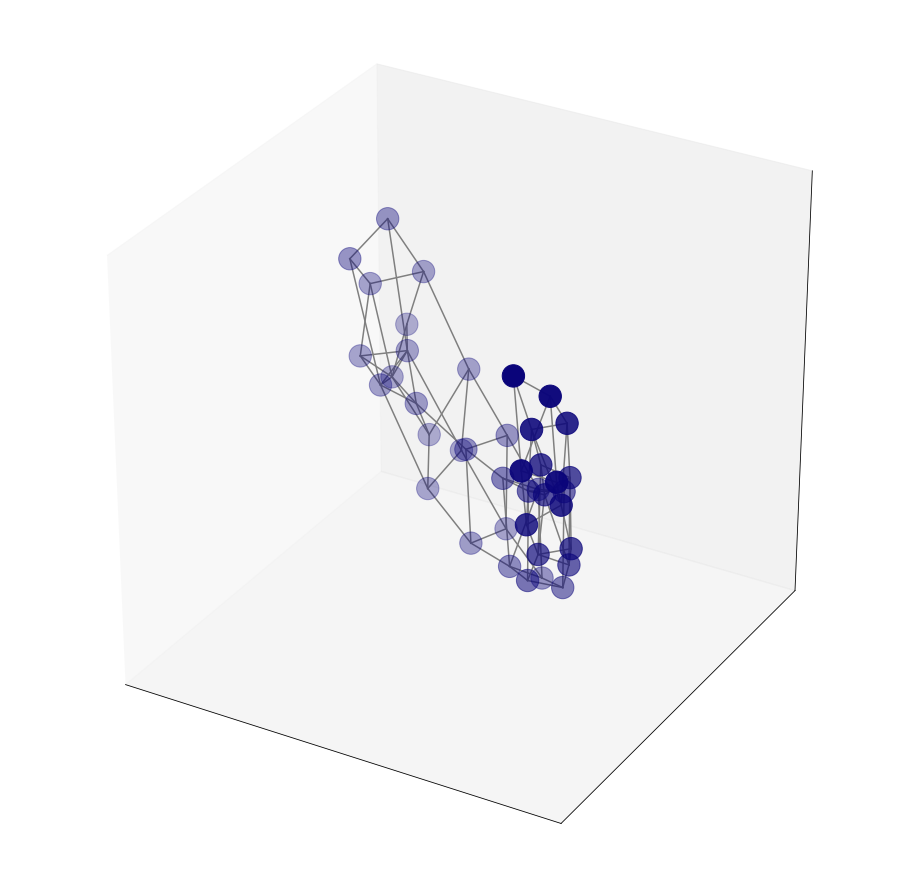

In [5]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[3], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

# Mini-batching

In [6]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 9116], x=[2398, 0], y=[64], batch=[2398], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 11226], x=[2931, 0], y=[64], batch=[2931], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 7350], x=[1961, 0], y=[64], batch=[1961], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 6622], x=[1785, 0], y=[64], batch=[1785], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 7552], x=[2017, 0], y=[64], batch=[2017], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 10212], x=[2798, 0], y=[64], batch=[2798], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 9358], x=[2467, 0], y=[64], batch=[2467], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 9248], x=[2575, 0], y=[64], batch=[2575], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 9890], x=[2591, 0], y=[64], batch=[2591], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 8680], x=[2298, 0], y=[64], bat

# GIN and GCN in PyTorch Geometric

In [12]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return hG, F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gcn = GCN(dim_h=32)
gin = GIN(dim_h=32)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


# Train

In [13]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for data in loader:
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y) / len(loader)
      acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = train(gcn, train_loader)
gin = train(gin, train_loader)

Epoch 100 | Train Loss: 0.67 | Train Acc: 60.96% | Val Loss: 0.68 | Val Acc: 57.35%
Test Loss: 0.71 | Test Acc: 51.82%
Epoch 100 | Train Loss: 0.54 | Train Acc: 73.55% | Val Loss: 0.65 | Val Acc: 63.88%
Test Loss: 0.62 | Test Acc: 66.93%


# Plot graph classification

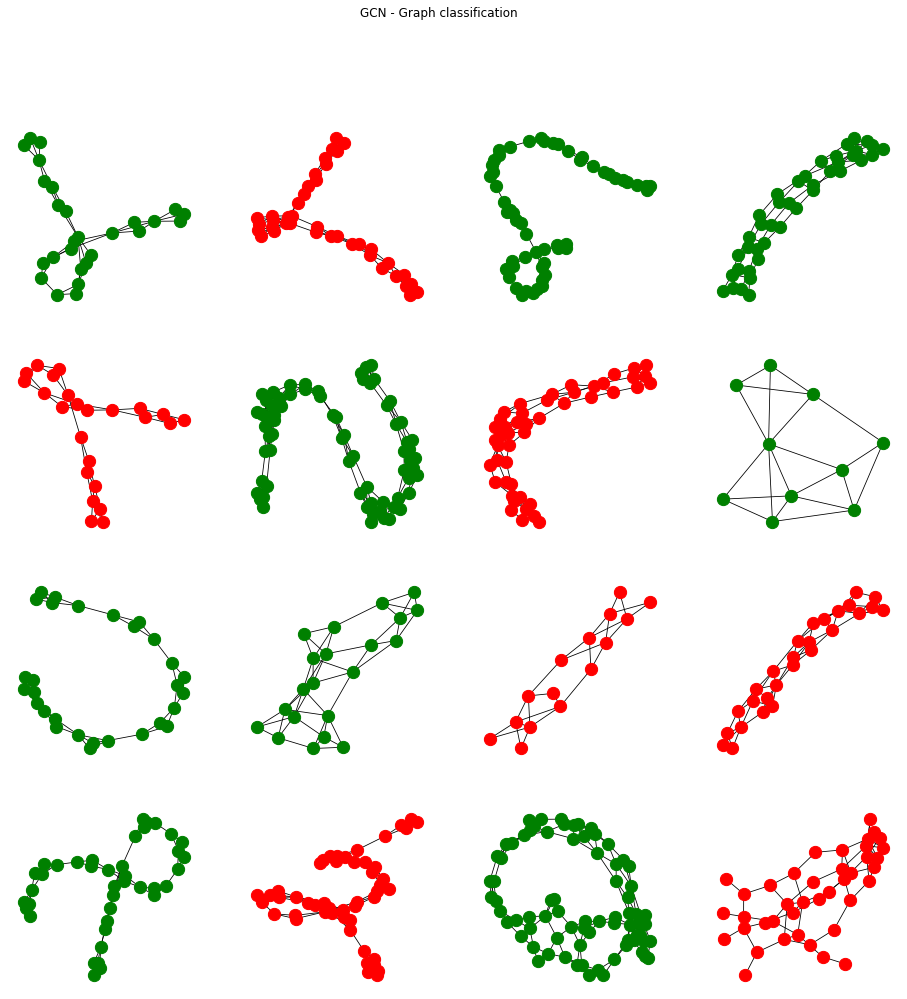

In [14]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

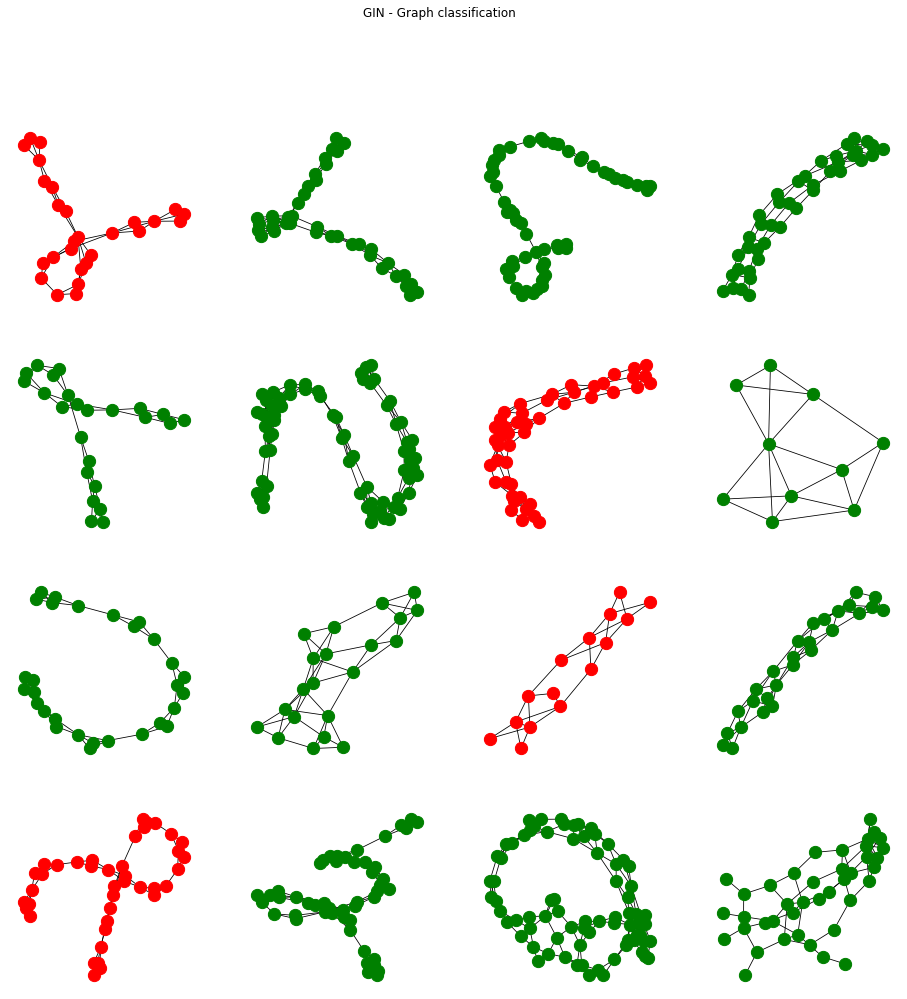

In [15]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

# Ensemble learning

In [16]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gcn = gcn(data.x, data.edge_index, data.batch)
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc*100:.2f}%')

GCN accuracy:     51.82%
GIN accuracy:     66.93%
GCN+GIN accuracy: 64.58%
